1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X.shape

(150, 2)

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
# стратификация - одинкаковое распределение Y на тесте и на трейне
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X.shape, y.shape

((120, 2), (30, 2), (120,), (30,), (150, 2), (150,))

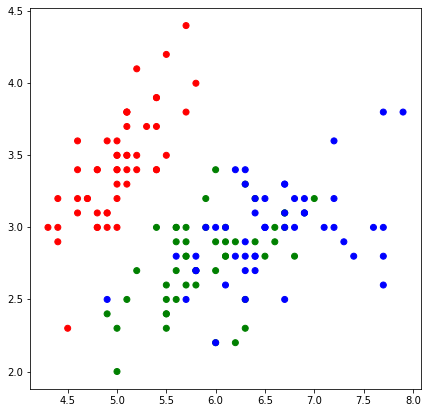

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем добавление весов.

Реализуем алгоритм поиска k ближайших соседей.

In [6]:
# {class_item: 0 for class_item in set(y_train)}

In [7]:
def knn(x_train, y_train, x_test, k):
    answers = []
    for x in x_test: # x = [2.5, 4.6]
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до каждого объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))  # массив [расст-е, ответ],...
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}  # {0:0, 1:0, 2:0}

        # Сортируем список по удалённости и среди первых k элементов подсчитаем частоту появления разных классов
        n = 1
        q = 0.9
        for d in sorted(test_distances)[0:k]:  # sorted(test_distances)[0:k] = [(0.09, 2), (0.14, 2)]
            # d = (0.141, 2) - расст-е, класс
#             print(d)
            weight = q ** n
#             print(f'weight={weight}')
            classes[d[1]] += weight  # classes={0: 0, 1: 0, 2: 1.0} - {класс: вес}
#             print(f'classes={classes}')
            n += 1
        
#         print(f'classes all={classes}')
#         print(f'classes sorted={sorted(classes, key=classes.get)} classes_last_elem={sorted(classes, key=classes.get)[-1]}')
        
        # Записываем в список класс с наибольшей суммой весов
        answers.append(sorted(classes, key=classes.get)[-1])
#         print('answers=', answers)
    return answers

Напишем функцию для вычисления точности

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [9]:
k = 2

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 2: 0.70000


Построим график распределения классов. Для этого сгенерируем 58800 тыс точек для закрашивания графика в соответсвие с настройкамии алгоритма предсказания. Таким образом мы получим области с предсказаниями.

Функция meshgrid() позволят получить матрицу координат из координатных векторов. Если, например, у нас есть два одномерных вектора координат, то передав их в качестве аргументов в meshgrid() мы получим две матрицы, в которой элементы будут составлять пары, заполняя все пространство, определяемое этими векторами. https://devpractice.ru/numpy-useful-functions/#p33

In [10]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02 # шаг с которым берутся точки

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    # Через meshgrid создается сетка из аргументов, матрица, с координатами всех точек
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    # ravel преобразовывает матрицу в 1-мерный вектор, по возможности без создания копии
    # Например: np.ravel(np.array([[1, 2, 3], [4, 5, 6]])) >>> array([1, 2, 3, 4, 5, 6])
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [11]:
# get_graph(X_train, y_train, k)

(58800, 2)


<ipython-input-10-332b4a09702e>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


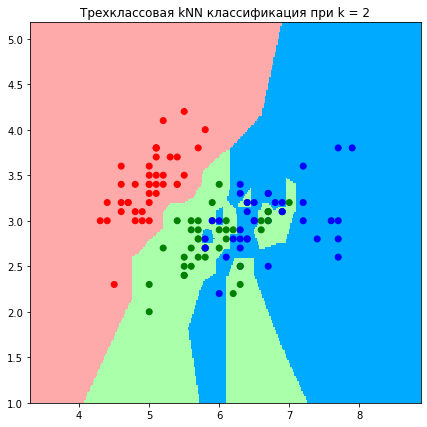

Wall time: 1min 34s


In [12]:
%%time
get_graph(X_train, y_train, k)

In [13]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 3: 0.73333


(58800, 2)


<ipython-input-10-332b4a09702e>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


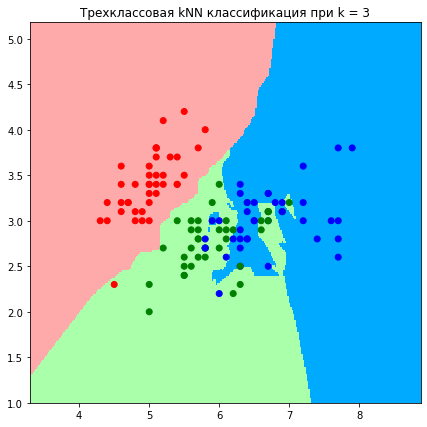

Wall time: 1min 35s


In [14]:
%%time
get_graph(X_train, y_train, k)

In [15]:
k = 5

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 5: 0.73333


(58800, 2)


<ipython-input-10-332b4a09702e>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


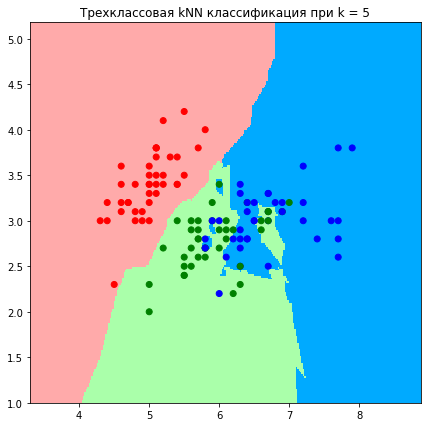

Wall time: 1min 27s


In [16]:
%%time
get_graph(X_train, y_train, k)

In [17]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.5f}')

Точность алгоритма при k = 10: 0.73333


(58800, 2)


<ipython-input-10-332b4a09702e>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


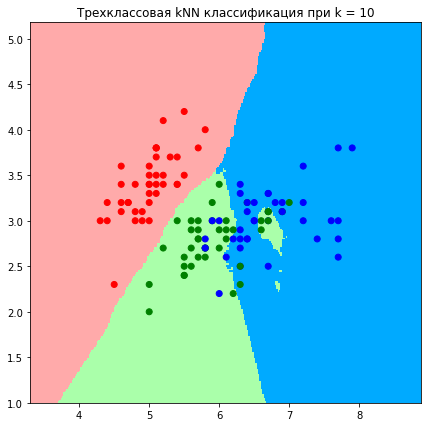

Wall time: 1min 31s


In [18]:
%%time
get_graph(X_train, y_train, k)

2. *Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

3. *Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).